In [2]:
import pandas as pd
import nltk
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback, TensorBoard
from keras.layers import Input, Embedding, Bidirectional, LSTM, Conv1D, MaxPooling1D, BatchNormalization, Flatten, Dense, Dropout, Reshape, Concatenate, Masking
from keras.regularizers import l2
from keras.utils import Sequence, to_categorical
from keras.optimizers import Adam
from keras.backend import epsilon
from keras.models import model_from_json
from keras.models import Model, Sequential

In [3]:
COLUMN_NAMES = ['id', 'label', 'statement', 'subject', 'speaker',
               'speakers_job', 'state_info', 'party_aff', 'bt_cnt',
               'f_cnt', 'ht_cnt', 'mt_cnt', 'pf_cnt', 'context',
               'justification']

In [4]:

train = pd.read_csv('./liar_dataset/train2.tsv',sep = '\t', names = COLUMN_NAMES)
valid = pd.read_csv('./liar_dataset/val2.tsv',sep = '\t', names = COLUMN_NAMES)
test = pd.read_csv('./liar_dataset/test2.tsv',sep = '\t', names = COLUMN_NAMES)

In [5]:
train = train.fillna('None')
valid = valid.fillna('None')
test = test.fillna('None')

In [6]:
train.shape,valid.shape,test.shape

((10242, 15), (1284, 15), (1267, 15))

In [7]:
train.head()

,id,label,statement,subject,speaker,speakers_job,state_info,party_aff,bt_cnt,f_cnt,ht_cnt,mt_cnt,pf_cnt,context,justification
0.0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1.0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2.0,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3.0,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,None,None,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4.0,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,None,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."


In [8]:
train.reset_index(drop=True,inplace=True)

In [9]:
train.head()

,id,label,statement,subject,speaker,speakers_job,state_info,party_aff,bt_cnt,f_cnt,ht_cnt,mt_cnt,pf_cnt,context,justification
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,None,None,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,None,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."


In [10]:
test.head()

,id,label,statement,subject,speaker,speakers_job,state_info,party_aff,bt_cnt,f_cnt,ht_cnt,mt_cnt,pf_cnt,context,justification
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview,"Meantime, engineering experts agree the wall w..."
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference,She cited layoff notices received by the state...
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.,"Trump said that McCain ""has done nothing to he..."
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show,"But spending still goes up. In addition, many ..."
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,None,Wisconsin,democrat,5,7,2,2,7,a web video,Our rating A Democratic Party web video making...


In [11]:
valid.head()

,id,label,statement,subject,speaker,speakers_job,state_info,party_aff,bt_cnt,f_cnt,ht_cnt,mt_cnt,pf_cnt,context,justification
0,12134.json,barely-true,We have less Americans working now than in the...,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,1,0,1,0,0,an interview with ABC17 News,"However, Hartzler was talking about the entire..."
1,238.json,pants-fire,"When Obama was sworn into office, he DID NOT u...","obama-birth-certificate,religion",chain-email,None,None,none,11,43,8,5,105,None,Ellison used a Koran that once belonged to Tho...
2,7891.json,false,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,0,1,1,1,0,a U.S. Ways and Means hearing,"However, we have two professors who say the la..."
3,8169.json,half-true,Says nearly half of Oregons children are poor.,poverty,jim-francesconi,Member of the State Board of Higher Education,Oregon,none,0,1,1,1,0,an opinion article,"In fact, if you use federal definitions for po..."
4,929.json,half-true,On attacks by Republicans that various program...,"economy,stimulus",barack-obama,President,Illinois,democrat,70,71,160,163,9,interview with CBS News,Obama's point is that some perspective is in o...


In [12]:

train.describe(), valid.describe(),test.describe()


(           id      label                                          statement  \
 count   10242      10242                                              10242   
 unique  10241          7                                              10224   
 top      None  half-true  On changing the rules for filibusters on presi...   
 freq        2       2114                                                  3   
 
             subject       speaker speakers_job state_info   party_aff  \
 count         10242         10242        10242      10242       10242   
 unique         3828          2911         1184         84          24   
 top     health-care  barack-obama         None       None  republican   
 freq            381           488         2900       2212        4497   
 
          bt_cnt    f_cnt   ht_cnt   mt_cnt   pf_cnt         context  \
 count   10242.0  10242.0  10242.0  10242.0  10242.0           10242   
 unique     31.0     31.0     30.0     28.0     21.0            4346   
 top      

In [13]:
train.info(),valid.info(),test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10242 entries, 0 to 10241
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             10242 non-null  object
 1   label          10242 non-null  object
 2   statement      10242 non-null  object
 3   subject        10242 non-null  object
 4   speaker        10242 non-null  object
 5   speakers_job   10242 non-null  object
 6   state_info     10242 non-null  object
 7   party_aff      10242 non-null  object
 8   bt_cnt         10242 non-null  object
 9   f_cnt          10242 non-null  object
 10  ht_cnt         10242 non-null  object
 11  mt_cnt         10242 non-null  object
 12  pf_cnt         10242 non-null  object
 13  context        10242 non-null  object
 14  justification  10242 non-null  object
dtypes: object(15)
memory usage: 1.2+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 1284 entries, 0 to 1283
Data columns (total 15 columns):
 #   Column      

(None, None, None)

In [14]:
train = train.fillna('None')
valid = valid.fillna('None')
test = test.fillna('None')


In [15]:

# Nan values counts
train.isna().sum()

id               0
label            0
statement        0
subject          0
speaker          0
speakers_job     0
state_info       0
party_aff        0
bt_cnt           0
f_cnt            0
ht_cnt           0
mt_cnt           0
pf_cnt           0
context          0
justification    0
dtype: int64

In [16]:
# Binary label translation
label_dict = {
    'half-true': 0,
    'false': 0,
    'mostly-true': 1,
    'true': 1,
    'barely-true': 1,
    'pants-fire': 0
}

train['binary_label'] = train['label'].map(label_dict)
valid['binary_label'] = valid['label'].map(label_dict)
test['binary_label'] = test['label'].map(label_dict)

In [17]:
def safe_int_conversion(value):
    try:
        return int(value)
    except (ValueError, TypeError):
        return None  # Handle non-convertible values

# Apply the safe_int_conversion function to each element in the column
train['binary_label'] = train['binary_label'].apply(safe_int_conversion)
train['bt_cnt'] = train['bt_cnt'].apply(safe_int_conversion)
train['f_cnt'] = train['f_cnt'].apply(safe_int_conversion)
train['ht_cnt'] = train['ht_cnt'].apply(safe_int_conversion)
train['mt_cnt'] = train['mt_cnt'].apply(safe_int_conversion)
train['pf_cnt'] = train['pf_cnt'].apply(safe_int_conversion)
# Remove rows with None values (non-convertible values)
train = train.dropna(subset=['binary_label'])
train[['bt_cnt','f_cnt','ht_cnt','mt_cnt','pf_cnt']] = train[['bt_cnt','f_cnt','ht_cnt','mt_cnt','pf_cnt']].fillna(value=0)
train['binary_label'] = train['binary_label'].astype('int')
train['bt_cnt'] = train['bt_cnt'].astype('int')
train['f_cnt'] = train['f_cnt'].astype('int')
train['ht_cnt'] = train['ht_cnt'].astype('int')
train['mt_cnt'] = train['mt_cnt'].astype('int')
train['pf_cnt'] = train['pf_cnt'].astype('int')

In [18]:
def get_top_counts(COL = 'subject'):
    plt.title('Top 10 value counts for col: {}'.format(COL))
    COLUMNS = ['name', 'counts']
    data = pd.DataFrame(np.array([train[COL].value_counts().index, train[COL].value_counts().values]).T, columns = COLUMNS)
    sns.barplot(x = COLUMNS[1], y = COLUMNS[0], data = data.iloc[:10, :]);

C:\Users\bhavs\anaconda3\envs\twitter\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bhavs\anaconda3\envs\twitter\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bhavs\anaconda3\envs\twitter\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


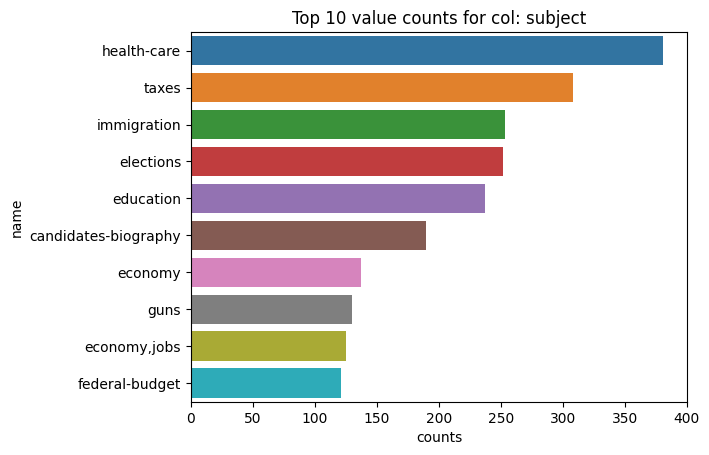

In [19]:

get_top_counts('subject')


C:\Users\bhavs\anaconda3\envs\twitter\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bhavs\anaconda3\envs\twitter\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bhavs\anaconda3\envs\twitter\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


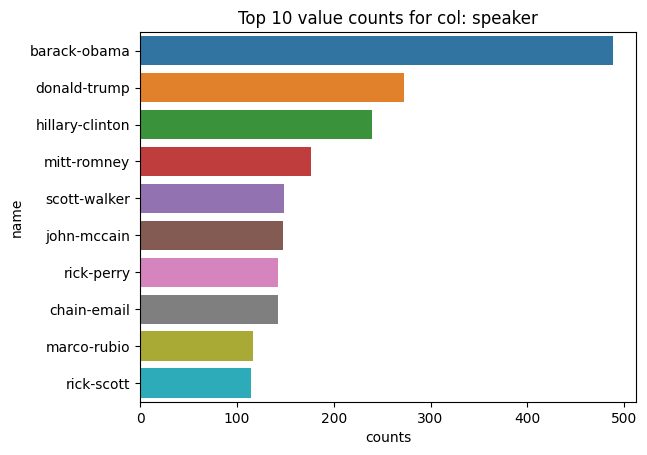

In [20]:
get_top_counts('speaker')

C:\Users\bhavs\anaconda3\envs\twitter\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bhavs\anaconda3\envs\twitter\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bhavs\anaconda3\envs\twitter\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


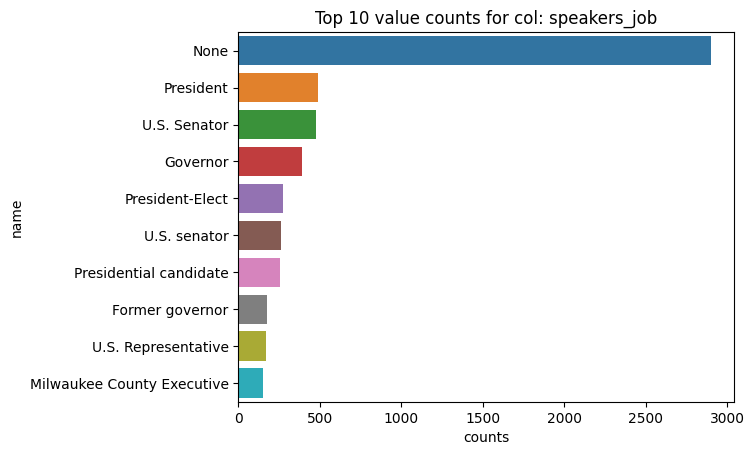

In [21]:
get_top_counts('speakers_job')

C:\Users\bhavs\anaconda3\envs\twitter\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bhavs\anaconda3\envs\twitter\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bhavs\anaconda3\envs\twitter\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


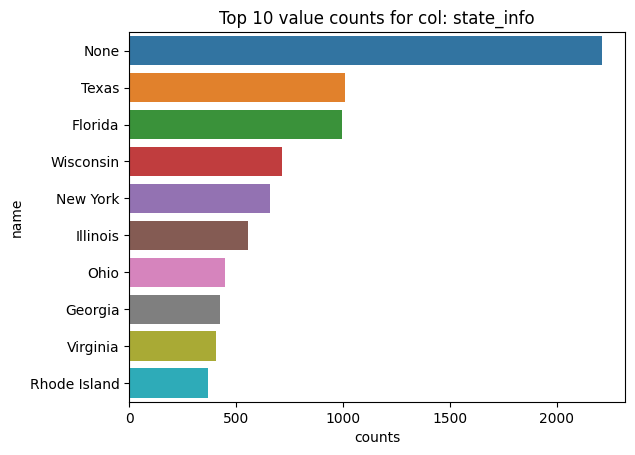

In [22]:
get_top_counts('state_info')


C:\Users\bhavs\anaconda3\envs\twitter\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bhavs\anaconda3\envs\twitter\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bhavs\anaconda3\envs\twitter\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


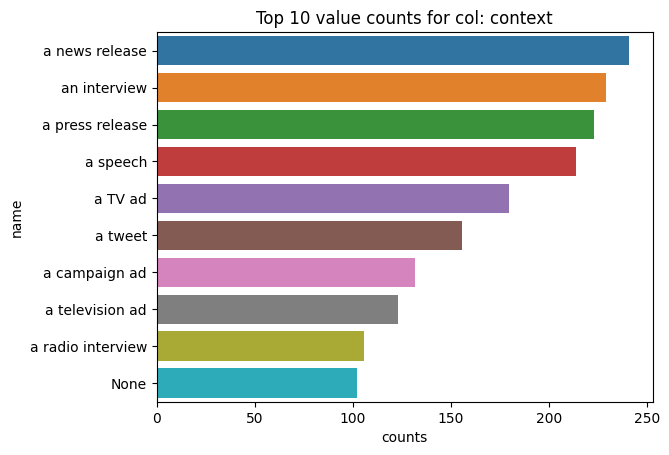

In [23]:

get_top_counts('context')


C:\Users\bhavs\anaconda3\envs\twitter\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bhavs\anaconda3\envs\twitter\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bhavs\anaconda3\envs\twitter\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


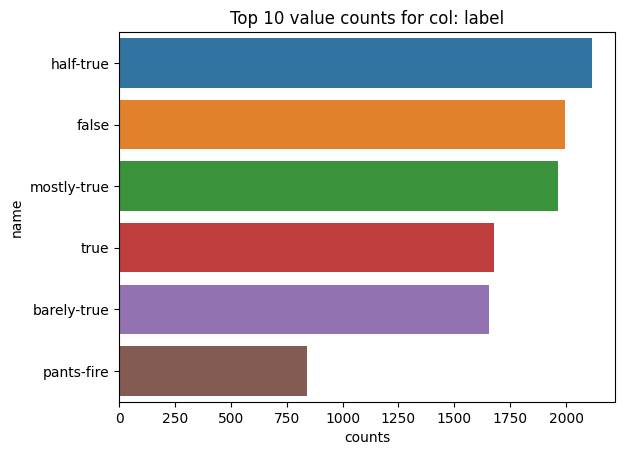

In [24]:

get_top_counts('label')


In [25]:

# Total number of unique values
for col in train.columns:
    if col != 'statement' and col != 'justification':
        print('Column: {}, unique values count: {}'.format(col, len(train[col].unique())))

Column: id, unique values count: 10240
Column: label, unique values count: 6
Column: subject, unique values count: 3828
Column: speaker, unique values count: 2911
Column: speakers_job, unique values count: 1184
Column: state_info, unique values count: 84
Column: party_aff, unique values count: 24
Column: bt_cnt, unique values count: 30
Column: f_cnt, unique values count: 30
Column: ht_cnt, unique values count: 29
Column: mt_cnt, unique values count: 27
Column: pf_cnt, unique values count: 20
Column: context, unique values count: 4346
Column: binary_label, unique values count: 2


In [26]:
from wordcloud import WordCloud, STOPWORDS

In [27]:
stopwords = set(STOPWORDS)
 
# TAKEN FROM: https://www.kaggle.com/gpreda/jigsaw-eda

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

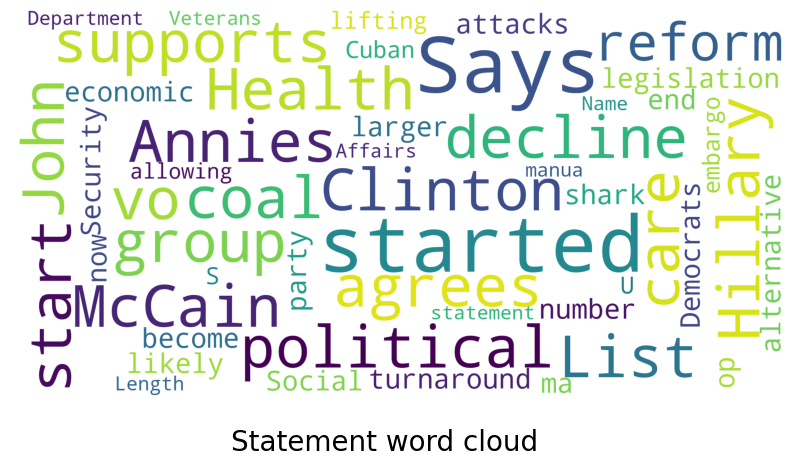

In [28]:
# Most common words for statement column
show_wordcloud(train['statement'], 'Statement word cloud')

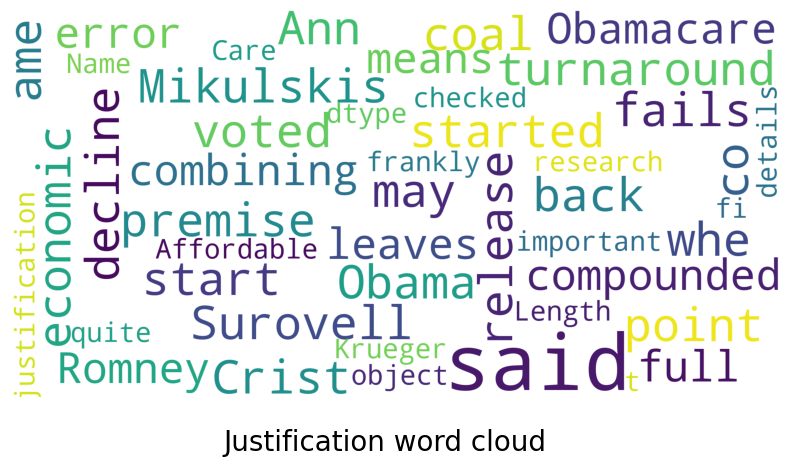

In [29]:
# Most common words for justification column
show_wordcloud(train['justification'], 'Justification word cloud')

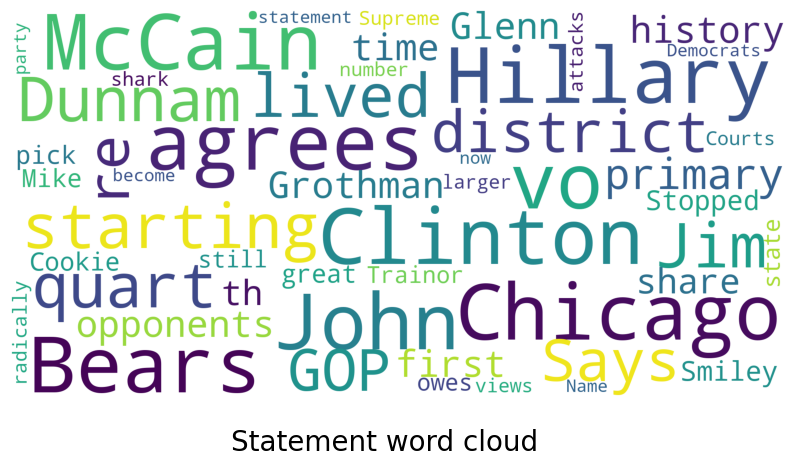

In [30]:
# Most common words for statement column, where label is 1
show_wordcloud(train[train['binary_label'] == 1]['statement'], 'Statement word cloud')


In [31]:
train.head()

,id,label,statement,subject,speaker,speakers_job,state_info,party_aff,bt_cnt,f_cnt,ht_cnt,mt_cnt,pf_cnt,context,justification,binary_label
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0,1,0,0,0,a mailer,That's a premise that he fails to back up. Ann...,0
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0,0,1,1,0,a floor speech.,"Surovell said the decline of coal ""started whe...",0
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70,71,160,163,9,Denver,Obama said he would have voted against the ame...,1
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,None,None,none,7,19,3,5,44,a news release,The release may have a point that Mikulskis co...,0
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,None,Florida,democrat,15,9,20,19,2,an interview on CNN,"Crist said that the economic ""turnaround start...",0


In [53]:
data = pd.concat([train, test, valid])

In [54]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings
#data = data_raw
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
def cleanHtml(sentence): #function to clear html points
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext
stop_words = list(set(stopwords.words('english')))
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)

def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)


def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r' ',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/|_|-]',r' ',cleaned)
    cleaned = re.sub(r'[X]+',r'',cleaned)  #removing XXXX type words
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

def keepAlpha(sentence): #function to keep only alpha value
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word.lower()
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent


def remove_short_words(text):   #here we will remove words which have length <=2
    cleaned_text = " ".join(word.strip() for word in text.split() if len(word)>2 )
            
    return cleaned_text

In [55]:
data['statement'] = data['statement'].apply(cleanHtml)
data['statement'] = data['statement'].apply(removeStopWords)
data['statement'] = data['statement'].apply(cleanPunc)
data['statement'] = data['statement'].apply(keepAlpha)
data['statement'] = data['statement'].apply(remove_short_words)
data['justification'] = data['justification'].apply(cleanHtml)
data['justification'] = data['justification'].apply(removeStopWords)
data['justification'] = data['justification'].apply(cleanPunc)
data['justification'] = data['justification'].apply(keepAlpha)
data['justification'] = data['justification'].apply(remove_short_words)

In [57]:
# Removing .json extension
data['id'] = data['id'].str.rstrip('.json')

In [58]:
data.columns

Index(['id', 'label', 'statement', 'subject', 'speaker', 'speakers_job',
       'state_info', 'party_aff', 'bt_cnt', 'f_cnt', 'ht_cnt', 'mt_cnt',
       'pf_cnt', 'context', 'justification', 'binary_label'],
      dtype='object')

In [59]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_label = LabelEncoder()

In [60]:
labelencoder_label.fit(data.iloc[:,1].values)
data.iloc[:,1]=labelencoder_label.transform(data.iloc[:,1])

In [63]:
# Train test split before by random_seed=fixed


# k-Fold Cross Validation

X = data.iloc[:, [2, 3,4,5,6,7,8,9,10,11,12,13]]
y = data.iloc[:, -1]

In [65]:
y.head()

0    0
1    0
2    1
3    0
4    0
Name: binary_label, dtype: int64

In [66]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [67]:
X_train_1 = X_train
X_test_1 = X_test
y_train_1 = y_train
y_test_1 = y_test

In [68]:
X_train_cat = X_train.loc[:,['speaker', 'speakers_job',
       'state_info', 'party_aff','context']]
X_test_cat = X_test.loc[:,['speaker', 'speakers_job',
       'state_info', 'party_aff','context']]

In [69]:
X_train_cat.head()

,speaker,speakers_job,state_info,party_aff,context
581,richard-licht,state director of administration in Rhode Island,Rhode Island,democrat,TV interview
910,lynn-westmoreland,None,None,republican,a press release on the House GOP's blog.
8389,rick-perry,Governor,Texas,republican,remarks at the Cornerstone Action Dinner in Ma...
674,rick-perry,Governor,Texas,republican,a press release
4893,viral-image,None,None,none,a Facebook post


In [70]:
X_train_cat.shape, X_test_cat.shape

((10232, 5), (2559, 5))

In [71]:
labelencoder = LabelEncoder()
labelencoder.fit(X_train_cat.iloc[:,0].values)
X_train_cat.iloc[:,0]=labelencoder.transform(X_train_cat.iloc[:,0])

In [72]:
labelencoder.fit(X_test_cat.iloc[:,0].values)
X_test_cat.iloc[:,0]=labelencoder.transform(X_test_cat.iloc[:,0])

In [73]:
labelencoder.fit(X_train_cat.iloc[:,1].values)
X_train_cat.iloc[:,1]=labelencoder.transform(X_train_cat.iloc[:,1])

In [74]:
labelencoder.fit(X_test_cat.iloc[:,1].values)
X_test_cat.iloc[:,1]=labelencoder.transform(X_test_cat.iloc[:,1])

In [75]:
labelencoder.fit(X_train_cat.iloc[:,2].values)
X_train_cat.iloc[:,2]=labelencoder.transform(X_train_cat.iloc[:,2])

In [76]:
labelencoder.fit(X_test_cat.iloc[:,2].values)
X_test_cat.iloc[:,2]=labelencoder.transform(X_test_cat.iloc[:,2])

In [77]:
labelencoder.fit(X_train_cat.iloc[:,3].values)
X_train_cat.iloc[:,3]=labelencoder.transform(X_train_cat.iloc[:,3])

In [78]:
labelencoder.fit(X_test_cat.iloc[:,3].values)
X_test_cat.iloc[:,3]=labelencoder.transform(X_test_cat.iloc[:,3])

In [79]:
labelencoder.fit(X_train_cat.iloc[:,4].values)
X_train_cat.iloc[:,4]=labelencoder.transform(X_train_cat.iloc[:,4])

In [80]:
labelencoder.fit(X_test_cat.iloc[:,4].values)
X_test_cat.iloc[:,4]=labelencoder.transform(X_test_cat.iloc[:,4])

In [81]:
X_train_cat.head()

,speaker,speakers_job,state_info,party_aff,context
581,2287,1173,52,7,255
910,1691,575,42,21,1606
8389,2300,393,61,21,4007
674,2300,393,61,21,1594
4893,2788,575,42,18,382


In [82]:
X_train_cont = X_train.loc[:,['bt_cnt', 'f_cnt', 'ht_cnt', 'mt_cnt','pf_cnt']]
X_test_cont = X_test.loc[:,['bt_cnt', 'f_cnt', 'ht_cnt', 'mt_cnt','pf_cnt']]

In [83]:
X_train_cont.head()

,bt_cnt,f_cnt,ht_cnt,mt_cnt,pf_cnt
581,0,0,0,0,0
910,1,1,3,0,0
8389,30,30,42,23,18
674,30,30,42,23,18
4893,5,5,0,3,15


In [85]:
X_train_text = X_train.loc[:,['statement']]
X_test_text = X_test.loc[:,['statement']]

In [86]:
X_train_text.head()

,statement
581,proposed fees rhode island beaches still less ...
910,war spending bill actually spends money intern...
8389,energy efficiency legislation sponsored sen je...
674,debating
4893,unions create eight hour work day hour work we...


In [87]:
y_train.head()

581     1
910     1
8389    0
674     0
4893    1
Name: binary_label, dtype: int64

In [88]:
# Converting the Text into list
stat_data_train = X_train_text['statement'].tolist()
stat_data_test = X_test_text['statement'].tolist()
#stat_test = test['Statement'].tolist()

# Adding data and test data
lis_stat = stat_data_train + stat_data_test

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [91]:
#Fitting TFIDF on summary
tfv_sum = TfidfVectorizer(max_features=5000, lowercase=True, analyzer='word',
 stop_words= 'english',ngram_range=(1,3))
# Fitting TF-IDF to both dataing and data sets (semi-supervised learning)
tfv_sum.fit(lis_stat)
print(tfv_sum.vocabulary_)
print(tfv_sum.idf_)
xtrain_tfv_sum =  tfv_sum.transform(stat_data_train).toarray()
xtest_tfv_sum = tfv_sum.transform(stat_data_test).toarray()
type(xtrain_tfv_sum)

{'proposed': 3334, 'fees': 1468, 'rhode': 3667, 'island': 2103, 'beaches': 337, 'town': 4589, 'rhode island': 3668, 'war': 4836, 'spending': 4185, 'actually': 48, 'spends': 4191, 'money': 2657, 'international': 2069, 'fund': 1592, 'energy': 1315, 'efficiency': 1266, 'legislation': 2315, 'sponsored': 4201, 'sen': 4004, 'jeanne': 2124, 'shaheen': 4064, 'federal': 1446, 'bureaucrats': 494, 'local': 2368, 'building': 485, 'code': 743, 'enforcement': 1317, 'city': 690, 'called': 520, 'green': 1729, 'mandates': 2459, 'jeanne shaheen': 2125, 'unions': 4694, 'create': 929, 'hour': 1917, 'work': 4941, 'day': 1005, 'week': 4874, 'says': 3798, 'space': 4167, 'required': 3622, 'car': 557, 'letting': 2325, 'bush': 498, 'tax': 4405, 'cuts': 978, 'expire': 1394, 'raise': 3415, 'taxes': 4436, 'small': 4127, 'businesses': 508, 'bush tax': 500, 'tax cuts': 4413, 'raise taxes': 3419, 'taxes small': 4443, 'small businesses': 4129, 'bush tax cuts': 501, 'taxes small businesses': 4444, 'scott': 3961, 'walke

numpy.ndarray

In [92]:
xtrain_tfv_sum.shape

(10232, 5000)

In [93]:
X_train = np.concatenate((X_train_cont, xtrain_tfv_sum,X_train_cat),axis = 1)
#x_data = np.concatenate((x1, xdata_tfv_sum, rest_df_data),axis = 1)

In [94]:
X_test = np.concatenate((X_test_cont, xtest_tfv_sum,X_test_cat),axis = 1)

In [95]:
X_train.shape, X_test.shape

((10232, 5010), (2559, 5010))

In [96]:
X_train

array([[0, 0, 0, ..., 52, 7, 255],
       [1, 1, 3, ..., 42, 21, 1606],
       [30, 30, 42, ..., 61, 21, 4007],
       ...,
       [6, 5, 7, ..., 67, 21, 614],
       [1, 0, 5, ..., 42, 7, 1818],
       [3, 2, 5, ..., 47, 7, 2285]], dtype=object)

In [97]:
# Fitting Naive Bayes to the Training set
from sklearn.naive_bayes import MultinomialNB
classifier_nb = MultinomialNB()
classifier_nb.fit(X_train, y_train)
y_pred_nb = classifier_nb.predict(X_test)

In [98]:
from sklearn.metrics import accuracy_score #
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report

In [99]:
np.unique(y_train)

array([0, 1], dtype=int64)

In [100]:
y_pred_nb

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [102]:
accuracy_score(y_test, y_pred_nb)

0.5400547088706525

In [103]:
from sklearn.linear_model import LogisticRegression
classifier_lr=LogisticRegression(solver='lbfgs' ,multi_class='multinomial')
classifier_lr.fit(X_train, y_train)
y_pred_lr = classifier_lr.predict(X_test)

In [104]:
accuracy_score(y_test, y_pred_lr)

0.6072684642438453

In [105]:
# Fitting Decision Tree Classification to the Training set
from sklearn.tree import DecisionTreeClassifier
classifier_dt = DecisionTreeClassifier()
classifier_dt.fit(X_train, y_train)

# Predicting the Test set results
y_pred_dt = classifier_dt.predict(X_test)

In [106]:
accuracy_score(y_test, y_pred_dt)

0.643220007815553